In [2]:
import time
import subprocess
import itertools
import pickle
import numpy
from numpy.random import default_rng
import matplotlib.pyplot as plt
import pandas
import slab

**Read musical stimulus**

In [5]:
file = "regular_major_1.csv"

def read_melody(file):
    score_data = pandas.read_csv(file, sep=";") #open the csv file with notes
    onsets = score_data.onset_sec.to_list()  #list of onsets of consecutive notes
    freq = score_data.freq.to_list() #frequencies of consecutive notes
    frequencies = [float(f.replace(",", ".")) for f in freq] #replace , with . in the frequencies
    durations = score_data.duration_sec.to_list() #note durations
    boundaries = score_data.boundary.to_list() #0 or 1 indication if the note is the beginning of a new phrase
    onsets.append(onsets[-1] + durations[-1] + 0.1) #I add a dummy note here
    durations.append(0.1) #I add a dummy note here
    return onsets, frequencies, durations, boundaries

onsets, frequencies, durations, boundaries = read_melody(file)


**Create an experimental sequence**

In [7]:
def create_sequence(boundaries, dev_freq, subject):
    boundaries_df = pandas.DataFrame(boundaries, columns=['boundary'])
    boundaries_df['idx'] = range(len(boundaries_df))

    #so this part creates a sequence for location change
    n_notes = boundaries.count(0)
    n_boundaries = boundaries.count(1)

    n_reps_notes = round((100 * n_notes)/(100+100*dev_freq))
    n_reps_boundaries = round((100 * n_boundaries)/(100+100*dev_freq))

    s_notes = slab.Trialsequence(conditions=1, n_reps=n_reps_notes, deviant_freq=dev_freq)
    s_notes_df = pandas.DataFrame(s_notes, columns=['sequence'])
    seq_zeros = s_notes_df['sequence']
    s_zeros = seq_zeros.to_list()

    s_boundaries = slab.Trialsequence(conditions=1, n_reps=10, deviant_freq=dev_freq)
    s_boundaries_df = pandas.DataFrame(s_boundaries, columns=['sequence'])
    seq_ones = s_boundaries_df['sequence']
    s_ones = seq_ones.to_list()

    bound_zeros = boundaries_df.loc[boundaries_df['boundary'] == 0]
    if len(s_zeros) > len(bound_zeros):
        s_zeros = s_ones[ :len(bound_zeros)]
    elif len(s_zeros) < len(bound_zeros):
        s_zeros.append(1)
    bound_zeros.insert(1, 'sequence', s_zeros)

    bound_ones = boundaries_df.loc[boundaries_df['boundary'] == 1]
    if len(s_ones) > len(bound_ones):
        s_ones = s_ones[ :len(bound_ones)]
    bound_ones.insert(1,'sequence', s_ones)

    frames = [bound_zeros, bound_ones]
    sequence = pandas.concat(frames)
    temp_seq = sequence.sort_values(by='idx', ascending=True)

    #this part is to give cues without location change, at 20% rate

    n_locchange = ((temp_seq['sequence']).tolist()).count(0)
    n_locstay = ((temp_seq['sequence']).tolist()).count(1)

    n_reps_locchange = round((100 * n_locchange)/(100+100*dev_freq))
    n_reps_locstay = round((100 * n_locstay)/(100+100*dev_freq))

    s_locchange = slab.Trialsequence(conditions=1, n_reps=n_reps_locchange, deviant_freq=dev_freq)
    s_locchange_df = pandas.DataFrame(s_locchange, columns=['cue'])
    seq_locchange = s_locchange_df['cue']
    s_locchange = seq_locchange.to_list()

    s_locstay = slab.Trialsequence(conditions=1, n_reps=n_locstay, deviant_freq=dev_freq)
    s_locstay_df = pandas.DataFrame(s_locstay, columns=['cue'])
    seq_locstay = s_locstay_df['cue']
    s_locstay = seq_locstay.to_list()

    bound_locchange = temp_seq.loc[temp_seq['sequence'] == 0]
    if len(s_locchange) > len(bound_locchange):
        s_locchange = s_locchange[ :len(bound_locchange)]
    elif len(s_locchange) < len(bound_locchange):
        s_locchange.append(1)
    bound_locchange.insert(1, 'cue', s_locchange)

    bound_locstay = temp_seq.loc[temp_seq['sequence'] == 1]
    if len(s_locstay) > len(bound_locstay):
        s_locstay = s_locstay[ :len(bound_locstay)]
    bound_locstay.insert(1,'cue', s_locstay)

    frames_f = [bound_locchange, bound_locstay]
    seq_f = pandas.concat(frames_f)
    final = seq_f.sort_values(by='idx', ascending=True)
    final.to_csv(
        f"/Users/zofiaholubowska/Documents/PhD/experiment/musicsyn/Results/{subject}/{subject}_seq.csv",
    )
    return final


final = create_sequence(boundaries, 0.25, "ZH")



Wszystko działa, sekwencja zapisuje się we właściwym pliku, w podfolderze dla konkretnej osoby badanej.

*Number of instances, when there is a location change and visual at the phrase boundary*

In [8]:
final.loc[(final['boundary'] == 1) & (final['cue'] == 0) & (final['sequence'] == 0)]

,boundary,cue,sequence,idx
80,1,0,0,80


*Plot showing the distribution of notes visual_cue/loc_change*

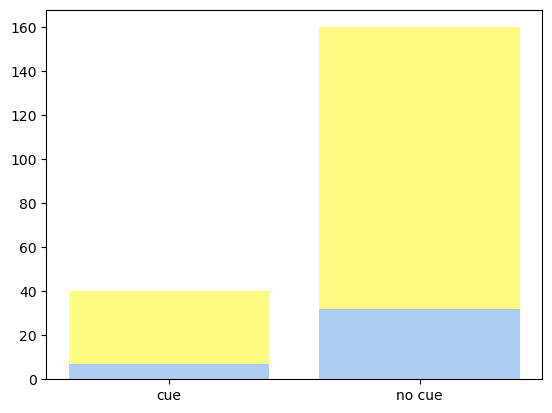

In [9]:
cue = final.loc[final['cue'] == 0]
no_cue = final.loc[final['cue'] == 1]

loc_change = cue.loc[cue['sequence'] == 0]
loc_stay = cue.loc[cue['sequence'] == 1]

loc_change_no = no_cue.loc[no_cue['sequence'] == 0]
loc_stay_no = no_cue.loc[no_cue['sequence'] == 1]

lc = len(loc_change)
ls = len(loc_stay)
lcn = len(loc_change_no)
lsn = len(loc_stay_no)
lc,ls,lcn,lsn

x = ['cue', 'no cue']
y1 = [lc, lcn]
y2 = [ls, lsn]

plt.bar(x, y1, color="#abcdef")
plt.bar(x, y2, bottom=y1, color="#fcfc83")
plt.show()

*Plot showing the distribution of notes loc_change/visual_cue*

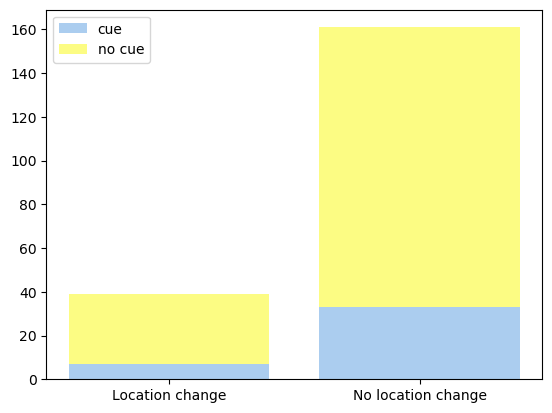

In [10]:
loc_change = final.loc[final['sequence'] == 0]
loc_stay = final.loc[final['sequence'] == 1]

cue = loc_change.loc[loc_change['cue'] == 0]
no_cue = loc_change.loc[loc_change['cue'] == 1]

cue_stay = loc_stay.loc[loc_stay['cue'] == 0]
no_cue_stay = loc_stay.loc[loc_stay['cue'] == 1]

c = len(cue)
nc = len(no_cue)
cs = len(cue_stay)
ncs = len(no_cue_stay)
c, nc, cs, ncs

x = ['Location change', 'No location change']
y1 = [c, cs]
y2 = [nc, ncs]

plt.bar(x, y1, color="#abcdef",label = "cue" )
plt.bar(x, y2, bottom=y1, color="#fcfc83", label = "no cue")
plt.legend()
plt.show()

**Read the results file and add it to the sequence, to have full data**

In [18]:
def subject_data(subject, file):
    """
    This is to create a dataframe with results and the sequence
    """
    
    data = slab.ResultsFile.read_file(file)

    timestamps = [float(list(d.keys())[0]) for d in data]
    frequencies = [list(d.values())[0] for d in data]
    responses = numpy.zeros_like(frequencies)

    df = pandas.DataFrame(
        {"Timestamp": timestamps, "Frequency": frequencies, "Responses": responses}
    )

    answers = df[df["Frequency"].astype(str).str.isalpha()]
    ans = answers["Timestamp"].tolist()

    freq = df[~df["Frequency"].astype(str).str.isalpha()]

    freq = freq.reset_index(drop=True)

    for row in freq.index[:-1]:
        start = freq.loc[row][0]
        end = freq.loc[row + 1][0]
        if row < len(freq):
            if any(start <= x < end for x in ans if isinstance(x, (int, float))):
                freq.at[row, "Responses"] = 1
            else:
                freq.at[row, "Responses"] = 0

    start_last = freq.iloc[-1]["Timestamp"]
    if any(
        start_last <= x < (start_last + 1.5) for x in ans if isinstance(x, (int, float))
    ):
        freq.at[len(freq) - 1, "Responses"] = 1
    else:
        freq.at[len(freq) - 1, "Responses"] = 0

    seq = pandas.read_csv(f"/Users/zofiaholubowska/Documents/PhD/experiment/musicsyn/Results/{subject}/{subject}_seq.csv")

    data = seq.join(freq["Responses"])
    data = data.join(freq["Frequency"])
    data = data.drop(columns=["idx"])
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
    data = data[['Frequency', 'boundary', 'sequence','cue', 'Responses']]
    data = data.rename(columns={"boundary": "Boundary", "sequence": "Location_change", "cue": "Visual_cue"})
    print(data)

subject_data("ZH", "/Users/zofiaholubowska/Documents/PhD/experiment/musicsyn/Results/ZH/ZH_2023-10-13-10-28-23.txt")

      Frequency  Boundary  Location_change  Visual_cue  Responses
0    391.995436         0                0           1        0.0
1    329.627557         0                1           1        0.0
2    440.000000         0                0           0        0.0
3    293.664768         0                1           1        0.0
4    329.627557         0                0           1        0.0
..          ...       ...              ...         ...        ...
195         NaN         0                1           1        NaN
196         NaN         0                1           1        NaN
197         NaN         0                1           1        NaN
198         NaN         0                1           1        NaN
199         NaN         0                1           1        NaN

[200 rows x 5 columns]
